# 鎌田担当会 5.7.1-5.8

## 今回の概要

5.7章では、これまで実装したレイアを組み合わせてニューラルネットワークを構築する。<br>

ニューラルネットワークで行う処理を"レイヤ"単位で実装<br>
　・ReLUレイヤ<br>
　・Softmax-with-Lossレイヤ<br>
　・Affineレイヤ<br>
　・Softmaxレイヤ<br>

上記レイヤには、forwardとbackwardというメソッドが実装されており、<br>
データを順方向と逆方向に伝播することで、重みパラメータの勾配を効率的に求めることができる<br>

上記レイヤを自由に組み合わせることで自分の好きなネットワークを簡単に作ることできる<br>

<img src="algorithm.png">

## 5.7.2 誤差逆伝播法に対応したニューラルネットワークの実装

import pprint
import sys, os
from pathlib import Path
sys.path.append('..')
pprint.pprint( sys.path )

#os.path.exists('/Users/msykm/Desktop/deep-learning-from-scratch-master/common/presentation')
os.path.exists('../../../common/presentation')

In [1]:
import sys, os
from pathlib import Path
#sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
sys.path.append("../../../")
import numpy as np
from common.presentation.layers import * 
from common.presentation.gradient import numerical_gradient
from collections import OrderedDict

In [2]:
class TwoLayerNet:
    #-------------------------------------------------
    # __init__:初期化を行う
    #     @self
    #     @input_size:入力層のニューロンの数
    #     @hidden_size:隠れ層のニューロンの数
    #     @output_size:出力層のニューロンの数
    #     @weight_init_std:重み初期化時のガウス分布スケール
    #-------------------------------------------------
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # params:ニューラルネットのパラメータを保持する辞書型変数
        # 重みの初期化
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) # np.random.randnは平均0、標準偏差1の正規分布の乱数を生成する関数 初めにweight_init_std=0.01を掛けるのは大きすぎるから       
        self.params['b1'] = np.zeros(hidden_size) # zeros要素がすべてゼロの配列を作成
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()       
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        # layer:ニューラルネットワークのレイヤを保持する「順序付き」辞書型変数
        # レイヤの生成:順序付きで保存しているのがポイント（Affine1→Relu1→Affine2の順）
        #           これにより順伝播ではそのまま、逆伝播では逆からレイヤを呼び出すだけでOK
        # 注意点:     要素をまとめて追加した場合は順序を記憶してくれない

        self.lastLayer = SoftmaxWithLoss()
        # ニューラルネットワークの最後のレイヤ:ここではSoftmaxWithLossレイヤ

    #-------------------------------------------------
    # predict:認識（推論）を行う
    #     @self
    #     @x:画像データ（入力データ）
    #-------------------------------------------------
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    #-------------------------------------------------
    # loss:損失関数を求める
    #     @self
    #     @x:画像データ（入力データ）
    #     @t:教師データ
    #-------------------------------------------------
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    #-------------------------------------------------
    # accuracy:認識精度を求める
    #     @self
    #     @x:画像データ（入力データ）
    #     @t:教師データ
    #-------------------------------------------------
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) # argmaxで、数値が高いラベルのみを取り出す。
        if t.ndim != 1 : t = np.argmax(t, axis=1) #.ndim 次元数 #!=でないとき⇒1次元でないとき # argmaxで、正解のラベルを取り出す。

        accuracy = np.sum(y == t) / float(x.shape[0]) #y==tがTrueのものを１として合計して、それをデータの総数で割り算する。
        return accuracy

    #-------------------------------------------------
    # numerical_gradient:重みパラメータに対する勾配を数値微分によって求める（〜４章までと同様）
    #     @self
    #     @x:画像データ（入力データ）
    #     @t:教師データ
    #-------------------------------------------------
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    #-------------------------------------------------
    # gradient:重みパラメータに対する勾配を誤差逆伝播法によって求める
    #     @self
    #     @x:画像データ（入力データ）
    #     @t:教師データ
    #-------------------------------------------------
    def gradient(self, x, t):

        # ポイント:実際にレイヤとして実装した伝播を動かしている

        # forward:順伝播
        self.loss(x, t)

        # backward:逆伝播
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## 5.7.3 誤差逆伝播法の勾配確認

In [3]:
import sys, os
#sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
sys.path.append("../../../")
import numpy as np
from dataset.presentation.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:3.3140429927367865e-10
b1:1.9699997220095973e-09
W2:4.362229325689349e-09
b2:1.4006894387130763e-07


## 5.7.4 誤差逆伝播法を使った学習

In [5]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.presentation.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) #hidden_sizeは任意の数可能　PCの性能で適当に変えてください。

iters_num = 10000 #訓練データ数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.06941666666666667, 0.0681
train acc, test acc | 0.9007833333333334, 0.9043
train acc, test acc | 0.9212666666666667, 0.9236
train acc, test acc | 0.9343, 0.9322
train acc, test acc | 0.9462333333333334, 0.9449
train acc, test acc | 0.9497, 0.9476
train acc, test acc | 0.9571666666666667, 0.9536
train acc, test acc | 0.9612166666666667, 0.9566
train acc, test acc | 0.96455, 0.959
train acc, test acc | 0.9669, 0.963
train acc, test acc | 0.9694666666666667, 0.9643
train acc, test acc | 0.9717166666666667, 0.9677
train acc, test acc | 0.9738666666666667, 0.9677
train acc, test acc | 0.9750666666666666, 0.9691
train acc, test acc | 0.9771666666666666, 0.97
train acc, test acc | 0.9778833333333333, 0.9695
train acc, test acc | 0.9786, 0.9712


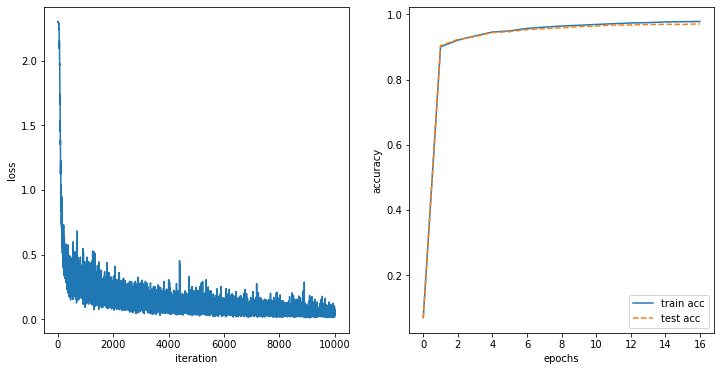

In [6]:
# グラフの描画
import matplotlib.pyplot as plt
markers = {'train': 'o', 'test': 's'}
x1 = np.arange(len(train_loss_list))
x2 = np.arange(len(train_acc_list))


# Figureオブジェクトを作成
fig = plt.figure(figsize=(12, 6))

# 1×2のfigureにオブジェクトを追加
ax = fig.add_subplot(1, 2, 1)
bx = fig.add_subplot(1, 2, 2)

# サブプロットaxのグラフのx軸、y軸にラベルを設定する
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
bx.set_xlabel("epochs")
bx.set_ylabel("accuracy")

# データx, yをグラフにプロットする
ax.plot(x1, train_loss_list)
bx.plot(x2, train_acc_list, label='train acc')
bx.plot(x2, test_acc_list, label='test acc', linestyle='--')
plt.legend(loc='lower right')
plt.show()

## まとめ

※概要再掲
ニューラルネットワークで行う処理を"レイヤ"単位で実装<br>
　・ReLUレイヤ<br>
　・Softmax-with-Lossレイヤ<br>
　・Affineレイヤ<br>
　・Softmaxレイヤ<br>

上記レイヤには、forwardとbackwardというメソッドが実装されており、<br>
データを順方向と逆方向に伝播することで、重みパラメータの勾配を効率的に求めることができる<br>

上記レイヤを自由に組み合わせることで自分の好きなネットワークを簡単に作ることできる<br>